# Sentiment Analysis on Movie Reviews: Analyzing performance of Non-negative Matrix Factorization and KMeans Clustering

**Jay Manvirk (Ivan Loginov)**<br/>
University of Colorado, Boulder<br/>
jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per sentiment](#chapter_4_2)
    - 4.3 [Word frequencies per sentiment](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Text cleaning](#chapter_5_1)
    - 5.3 [TF-IDF vectorization](#chapter_5_2)
6. [Model architectures](#chapter_6)
    - 6.1 [NMF](#chapter_6_1)
    - 6.2 [KMeans](#chapter_6_2)
7. [Model results](#chapter_7)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

TODO

# 2. Introduction <a class="anchor" id="chapter_2"></a>

In this study our objective is to compare the performance of two unsupervised machine learning models:
1. Non-Negative Matrix Factorization (NMF)
2. KMeans clustering

Our goal is to achieve the highest accuracy score without relying on labeled data during the training process.

We are examining the Sentiment Analysis on Movie Reviews dataset, available in the References section. This dataset comprises English phrases extracted from movie reviews, classified into five distinct sentiment categories:
1. negative
2. somewhat negative
3. neutral
4. somewhat positive
5. positive

The study is divided into four sections, leading to a conclusion:
1. **Exploratory data analysis:**<br/>
In this part we closely examine the dataset's details like its size, structure and words used. This analysis shapes how we process the data next.
2. **Data preprocessing:**<br/>
Using what we learned from our EDA, we clean the text and transform it using TF-IDF. These steps are essential to help NMF and KMeans find patterns in the data.
3. **Model architectures:**<br/>
In this part we introduce NMF and KMeans models and explain their details and settings.
4. **Model results:**<br/>
In our model testing results we present various configurations in a clear table format, along with brief explanations.

# 3. Libraries and data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [76]:
# basics
import os
import itertools
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from concurrent.futures import ProcessPoolExecutor
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Model architecture
from sklearn.decomposition import NMF
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [2]:
# Get files and directories in the input folder
files_dirs = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files_dirs.append(os.path.join(dirname, filename))

In [3]:
# Print files and directories
files_dirs

['/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv',
 '/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip',
 '/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip']

In [4]:
# Set datasets
sample_data = pd.read_csv(files_dirs[0], sep='\t')
train_data = pd.read_csv(files_dirs[1], sep='\t')
test_data = pd.read_csv(files_dirs[2], sep='\t')

In [5]:
# Cleaning
del files_dirs

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

The dataset includes 5 unique labels:
* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

The training and testing datasets can be considered of medium size:
* training set: 156 060 records, 4.8+ MB
* testing set: 66 292 records, 1.5+ MB
* submission set: 3 534 records, 55+ KB

In [6]:
def print_short_summary(name, data):
    """
    Print data head, shape and major info, including size in kB.
    
    Args:
        name (str): name of the dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2 Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

In [7]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  

2 Data shape: (156060, 4)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3),

In [8]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

2 Data shape: (66292, 3)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66291 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [9]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
  PhraseId,Sentiment
0           156061,2
1           156062,2
2           156063,2
3           156064,2
4           156065,2

2 Data shape: (66292, 1)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PhraseId,Sentiment  66292 non-null  object
dtypes: object(1)
memory usage: 518.0+ KB


In [10]:
# Cleaning
del print_short_summary

## 4.2 Number of records per sentiment <a class="anchor" id="chapter_4_2"></a>

The dataset reveals a great imbalance in the text distribution among classes. Typically, equalizing the number of samples per class through downsampling or upsampling is a common approach to solve such imbalance. The idea behind it is to improve model's ability to learn underlying patterns. However, downsampling can result in information loss, while upsampling may introduce biases in models. To retain maximal relevant information, we opt for utilizing the unsampled dataset.

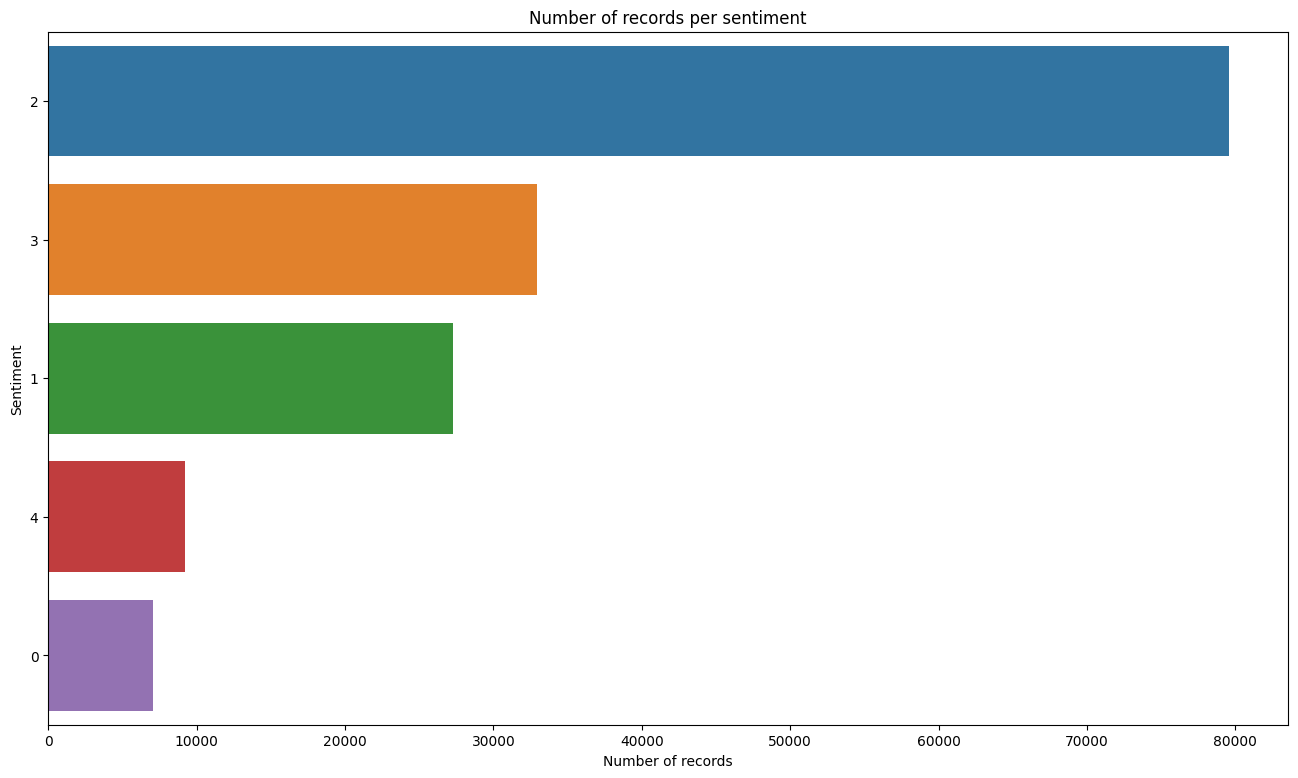

In [11]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['Sentiment'].value_counts().sort_values(ascending=False)
labels = tmp.index.values
sns.barplot(y=labels.astype(str), x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Sentiment')
plt.title('Number of records per sentiment')
plt.show()

In [12]:
# Cleaning
del tmp

## 4.3 Word frequencies per sentiment <a class="anchor" id="chapter_4_3"></a>

In analyzing the charts, it's clear that the most high-frequency words are shared among all classes, offering little discriminative power. They can be deemed as noise and we intend to address them in the following sections.

In [13]:
def plot_word_dist_label(labels, top_n_words = 10):
    """
    Plot charts with word frequencies per label.
    
    Args:
        labels: list of labels
        top_n_words (opt): how many top words to plot in one chart
    """
    n = len(labels)
    
    # Get the default seaborn's palette to match colours with the previous chart
    default_palette = sns.color_palette("deep")
    
    # Initialize subplots with 2 row and 3 columns
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(16, 9))
    
    # Plot word count per label in the respective rows
    for i in range(n):
        row = i // ncols
        col = i % ncols
        indexes = train_data['Sentiment'] == labels[i]
        w = train_data['Phrase'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[row, col].bar(l.index, l.values, color=default_palette[i])
        axes[row, col].set_title(labels[i])
        axes[row, col].set_xlabel('Words')
        axes[row, col].set_ylabel('Percentage of total word count (%)')
        
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

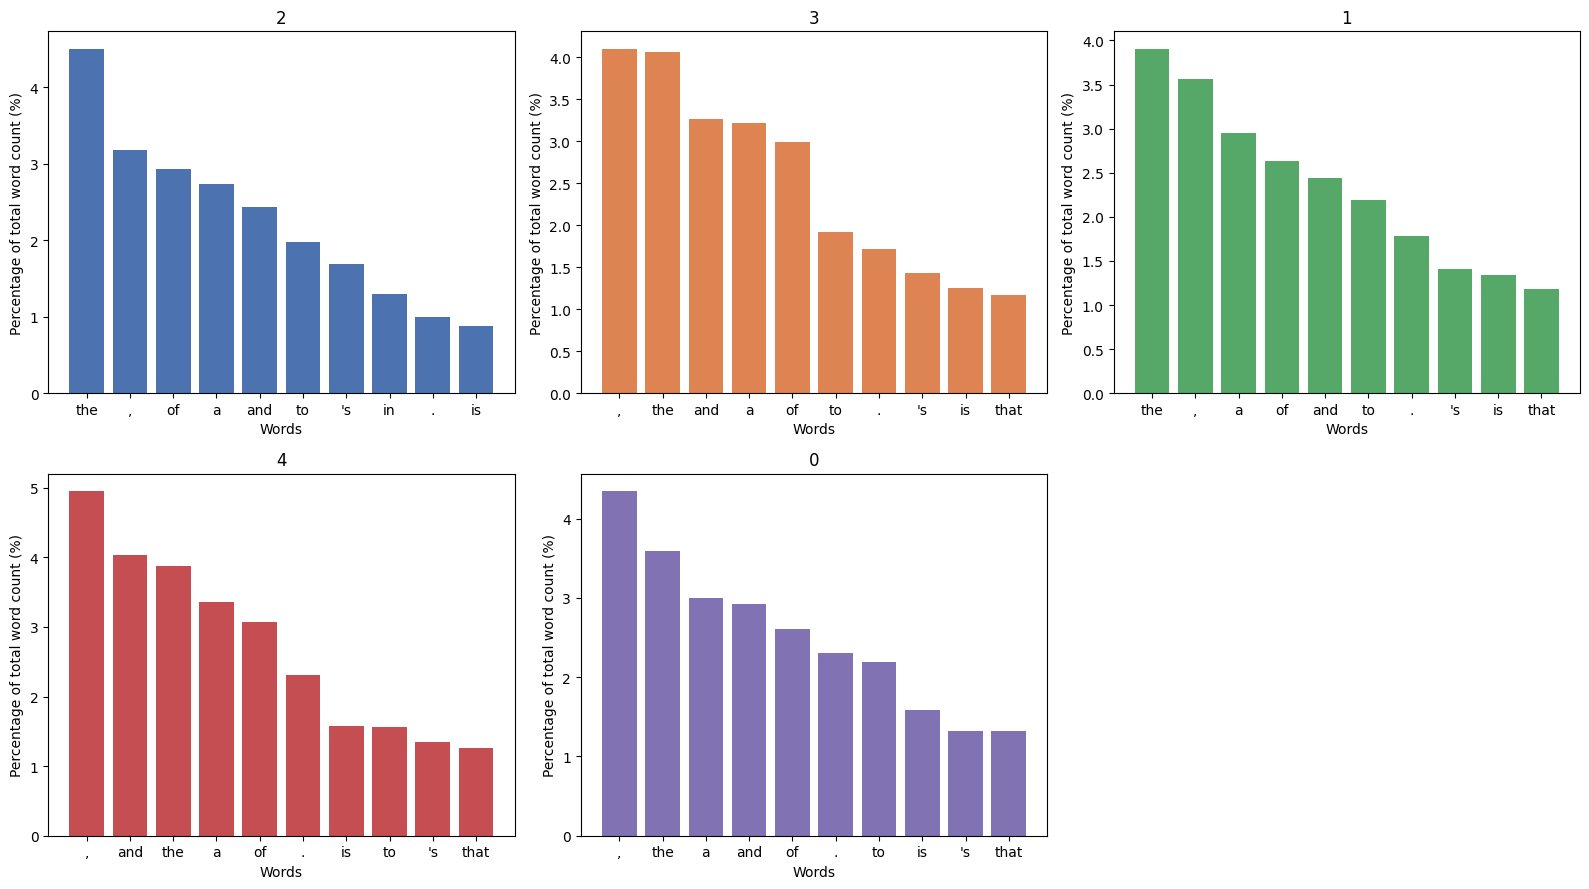

In [14]:
# Plot word frequencies per label
plot_word_dist_label(labels)

In [15]:
# Cleaning
del plot_word_dist_label, labels

# 5. Data preprocessing <a class="anchor" id="chapter_5"></a>

## 5.1 Text cleaning <a class="anchor" id="chapter_5_1"></a>

Based on our EDA findings, certain words introduce noise. Removing noise from the text allows our models to concentrate on essential patterns, improving training efficiency.<br/>
Additionally, we introduce lemmatization. This method reduces words to their base forms, shrinking the vocabulary size. This optimization enhances the computational efficiency of the following Word2Vec implementation. By disabling advanced components like parser and NER we significantly accelerate processing and reduce memory overhead.

In [19]:
# Load english lemmas dictionary without ner and parser
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern to match single letter, punctuation and digits
pattern = re.compile(r'\b([a-zA-Z])\b|[.,!?()-:;]\d+')

# Set english stopwords such as prepositions, articles, conjuctions etc.
stop_words = set(stopwords.words('english'))

In [43]:
def get_processed_text(text):
    """
    Return processed text of lemmas in lower register
    without punctuation, digits and single letters.
    
    Args:
        text (str): tweet text
    Returns:
        str: string of lemmatized tokens
    """
    # Convert to lowercase and remove digits, single letters
    text = pattern.sub('', text.lower())
    
    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]
    
    return ' '.join(lemmas)


def get_clean_text(texts):
    """
    Return cleaned text.
    Execution in parallel.
    
    Args:
        texts: numpy array of string elements
    Returns:
        ndarray: numpy array of tokenized lemmas
    """
    # Set up parallel tasks processing utilizing every CPU core
    with ProcessPoolExecutor() as executor:
        clean_tokens = list(executor.map(get_processed_text, texts))
        
    return clean_tokens

In [44]:
# Get cleaned train and test data
train_data_clean = get_clean_text(train_data['Phrase'].values)
test_data_clean = get_clean_text(test_data['Phrase'].values)

In [71]:
# Print an example of tokens
train_data_clean[0]

'  series escapade demonstrate adage good goose also good gander , occasionally amuse none amount much   story .'

In [ ]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_tokens, get_processed_tokens

## 5.2 TF-IDF Vectorization <a class="anchor" id="chapter_5_2"></a>

TODO

In [72]:
# Create vectorizer to convert plain text into feature matrix
vectorizer = TfidfVectorizer(sublinear_tf = True
                             , ngram_range = (1,2)
                             )
tfidf_vect = vectorizer.fit(train_data_clean)

In [81]:
# Transform cleaned data into matrix of word-weight features
X_train = tfidf_vect.transform(train_data_clean)
X_test = tfidf_vect.transform(test_data_clean)

y_train = train_data['Sentiment'].values

In [22]:
del vectorizer, tfidf_vect, test_data

# 6. Model architectures <a class="anchor" id="chapter_6"></a>

## 6.1 NMF <a class="anchor" id="chapter_6_1"></a>

TODO

In [75]:
class NMF_custom(BaseEstimator, ClassifierMixin):
    """
    Custom NMF class to use in conjunction with GridSearchCV
    , so that predict() function can be used in the cross validation.
    
    Args:
        BaseEstimator, ClassifierMixin: necessary for the GridSearchCV
    """
    def __init__(self, n_components = 5, init = None, l1_ratio = 0, max_iter = 200):
        """
        Set self variables to the arguments for the fit() function.
        
        Args:
            smaller set of the same arguments as in the docs of NMF
        """
        self.n_components = n_components
        self.init = init
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter

    def fit(self, X, y=None):
        """
        Fit NMF to the X data using self variables.
        
        Args:
            X (ndarray): data to fit
        Returns:
            self
        """
        self.nmf = NMF(n_components = self.n_components
                       , init = self.init
                       , l1_ratio = self.l1_ratio
                       , max_iter = self.max_iter)
        self.nmf.fit(X)
        return self

    def predict(self, X):
        """
        Transform X using fitted model to use as a prediction.
        
        Args:
            X (ndarray): data to predict from
        Returns:
            self.nmf.transform (ndarray): ndarray of predicted categories
        """
        return self.nmf.transform(X)

In [105]:
def get_grid(X_train = None
             , y_train = None
             , estimator = None
             , param_grid = None
             , scoring = 'balanced_accuracy'):
    """
    Return grid results from GridSearchCV.
    
    Args:
        X_train (ndarray): training data
        y_train (ndarray): training labels
    Returns:
        grid: results from GridSearchCV
    """
    # Create GridSearchCV object with custom scoring function and parallel exe
    grid = GridSearchCV(estimator = estimator
                        , param_grid = param_grid
                        , scoring = scoring
                        , return_train_score = True
                        , n_jobs = -1
                        , cv = 5)
    # Fit X_train
    grid = grid.fit(X_train, y_train)
  
    
    return grid

In [85]:
# Set parameters for GridSearchCV
param_grid = {
    'n_components': [5]
    ,'init': ['random', 'nndsvda']
    ,'l1_ratio': [0.0, 0.5, 1.0]
    ,'max_iter': [200, 400, 600]
}

In [ ]:
# Get grid results
grid = get_grid(X_train
                , y_train
                , NMF_custom()
                , param_grid
                , make_scorer(get_max_accuracy))

In [94]:
df = pd.DataFrame(grid.cv_results_)
df = df[['params','mean_test_score']]
df.sort_values(by=['mean_test_score'], ascending=[False])

,params,mean_test_score
1,"{'init': 'random', 'l1_ratio': 0.0, 'max_iter'...",0.392548
8,"{'init': 'random', 'l1_ratio': 1.0, 'max_iter'...",0.389273
12,"{'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter...",0.388171
17,"{'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter...",0.387569
13,"{'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter...",0.387518
14,"{'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter...",0.387306
4,"{'init': 'random', 'l1_ratio': 0.5, 'max_iter'...",0.387024
11,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.385134
9,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.384371
5,"{'init': 'random', 'l1_ratio': 0.5, 'max_iter'...",0.382962


## 6.2 KMeans <a class="anchor" id="chapter_6_2"></a>

TODO

In [106]:
# Set parameters for GridSearchCV
param_grid = {
    'n_clusters': [5],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-5, 1e-6],
    'algorithm': ['auto', 'full', 'elkan'],
}

In [107]:
grid = get_grid(X_train
                , y_train
                , KMeans()
                , param_grid)

In [110]:
df = pd.DataFrame(grid.cv_results_)
df = df[['params','mean_test_score']]
df.sort_values(by=['mean_test_score'], ascending=[False])

,params,mean_test_score
149,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.213540
156,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.210697
147,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.209375
25,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",0.207969
142,"{'algorithm': 'elkan', 'init': 'random', 'max_...",0.207038
...,...,...
17,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",0.189939
60,"{'algorithm': 'full', 'init': 'k-means++', 'ma...",0.187706
50,"{'algorithm': 'auto', 'init': 'random', 'max_i...",0.187400
128,"{'algorithm': 'elkan', 'init': 'k-means++', 'm...",0.186135


# 7. Model results <a class="anchor" id="chapter_7"></a>

TODO

In [74]:
def get_max_accuracy(y_true, y_pred):
    """
    Return max accuracy among category permutations.
    
    Args:
        y_true (ndarray): true labels of a dataset
        y_pred (ndarray): predicted lables from a model
    Returns:
        float: maximum accuracy score among all category permutations
    """
    y_pred = np.argmax(y_pred, axis = 1)
    l = np.unique(y_true)
    t = y_true
    mx = 0
    for p in itertools.permutations(range(len(l))):
        c = np.array([l[p.index(x)] for x in y_pred])
        v = np.mean(c == t)
        mx = max(mx,v)
            
    return mx

In [ ]:
# Print results table
table_results.reset_index(drop=True)

In [ ]:
# Cleaning
del config_models, config_data, table_results, table_nb
del get_grid, get_model_results, get_table_results_sorted, get_final_table_results

# 8. Submission results <a class="anchor" id="chapter_8"></a>

### Public score: ???

In [127]:
# Make submission
table_submis.to_csv('submission.csv', index=False)

In [ ]:
# Cleaning
del model, results, table_submis

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

TODO

# 10. References <a class="anchor" id="chapter_10"></a>

* Will Cukierski. (2014). Sentiment Analysis on Movie Reviews. Kaggle.<br/>
https://kaggle.com/competitions/sentiment-analysis-on-movie-reviews
* BBC News Classification: Matrix Factorization vs Supervised Learning<br/>
https://www.kaggle.com/code/jaymanvirk/matrix-factorization-nmf-vs-supervised-learning
* Scikit-learn Supervised learning<br/>
https://scikit-learn.org/stable/supervised_learning.html
* Launching parallel tasks<br/>
https://docs.python.org/3/library/concurrent.futures.html